In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cleaned_wait_times.csv')

In [3]:
metrics = ['50th Percentile', '90th Percentile', 'Volume', '% Meeting Benchmark']
df_filtered = df[
    (df['Reporting level'] == 'Provincial') &
    (df['Metric'].isin(metrics))
]

# Identify the two most recent years
years = sorted(df_filtered['Data year'].unique())
latest_year = years[-1]
prev_year = years[-2]

# Compute summary stats for each year and each metric
records = []
for year in [prev_year, latest_year]:
    df_year = df_filtered[df_filtered['Data year'] == year]
    for metric in metrics:
        vals = df_year[df_year['Metric'] == metric]['Indicator result']
        records.append({
            'Year': year,
            'Metric': metric,
            'Mean': vals.mean(),
            'Median': vals.median(),
            'StdDev': vals.std(),
            'Min': vals.min(),
            'Max': vals.max(),
            'Range': vals.max() - vals.min()
        })

stats_df = pd.DataFrame(records)
wide = stats_df.pivot(index='Metric', columns='Year')
wide

Mean              Median             StdDev  \
Year                       2022        2023    2022   2023        2022   
Metric                                                                   
% Meeting Benchmark   67.283333   68.983333   74.50   73.5   23.248905   
50th Percentile       56.953071   53.501071   24.00   25.0   81.438247   
90th Percentile      155.192214  154.118357   68.25   70.5  188.504365   
Volume               322.229167  327.475000  254.00  294.0  206.539423   

                                   Min           Max          Range          
Year                       2023   2022   2023   2022   2023    2022    2023  
Metric                                                                       
% Meeting Benchmark   20.881012  23.00  21.00  100.0  100.0   77.00   79.00  
50th Percentile       70.068602   0.62   0.83  467.0  318.0  466.38  317.17  
90th Percentile      182.126952   1.67   1.92  831.0  716.0  829.33  714.08  
Volume               183.440850  29.00  30.00  980.0  996.0  951.00  966.00

In [4]:
wide.columns = [f"{stat}_{year}" for stat, year in wide.columns]
wide['Mean_diff']   = wide[f"Mean_{latest_year}"] - wide[f"Mean_{prev_year}"]
wide['Median_diff'] = wide[f"Median_{latest_year}"] - wide[f"Median_{prev_year}"]
wide['StdDev_diff'] = wide[f"StdDev_{latest_year}"] - wide[f"StdDev_{prev_year}"]
wide['Range_diff']  = wide[f"Range_{latest_year}"] - wide[f"Range_{prev_year}"]

diff_cols = [c for c in wide.columns if c.endswith('_diff')]
wide[diff_cols]

,Mean_diff,Median_diff,StdDev_diff,Range_diff
Metric,,,,
% Meeting Benchmark,1.700000,-1.00,-2.367893,2.00
50th Percentile,-3.452000,1.00,-11.369645,-149.21
90th Percentile,-1.073857,2.25,-6.377413,-115.25
Volume,5.245833,40.00,-23.098572,15.00


In [5]:
median_df = df[
    (df['Metric'] == '50th Percentile') &
    (df['Reporting level'] == 'Provincial')
]

In [6]:
median_df.head()

,Reporting level,Province,Region,Indicator,Metric,Data year,Unit of measurement,Indicator result
0,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,50th Percentile,2008,Days,25.0
3,Provincial,Alberta,Calgary Zone,Breast Cancer Surgery,50th Percentile,2008,Days,19.0
7,Provincial,Alberta,Calgary Zone,CABG,50th Percentile,2008,Days,7.0
11,Provincial,Alberta,Calgary Zone,Cataract surgery,50th Percentile,2008,Days,70.0
14,Provincial,Alberta,Calgary Zone,Colorectal Cancer Surgery,50th Percentile,2008,Days,20.0


In [7]:
yearly_stats = (
    median_df
    .groupby('Data year')['Indicator result']
    .agg(Avg_Wait=('mean'), Median_Wait=('median'))
    .reset_index()
)

yearly_stats['YoY_Change_Avg'] = yearly_stats['Avg_Wait'].diff()
yearly_stats['YoY_Change_Median'] = yearly_stats['Median_Wait'].diff()

yearly_stats

,Data year,Avg_Wait,Median_Wait,YoY_Change_Avg,YoY_Change_Median
0,2008,38.941429,22.00,NaN,NaN
1,2009,37.498143,22.00,-1.443286,0.00
2,2010,35.844786,22.00,-1.653357,0.00
3,2011,38.164714,21.00,2.319929,-1.00
4,2012,39.097929,21.00,0.933214,0.00
5,2013,36.141143,19.75,-2.956786,-1.25
6,2014,35.711357,22.00,-0.429786,2.25
7,2015,37.512071,22.00,1.800714,0.00
8,2016,40.459286,22.00,2.947214,0.00
9,2017,43.363500,22.00,2.904214,0.00


Visualization of RQ 1

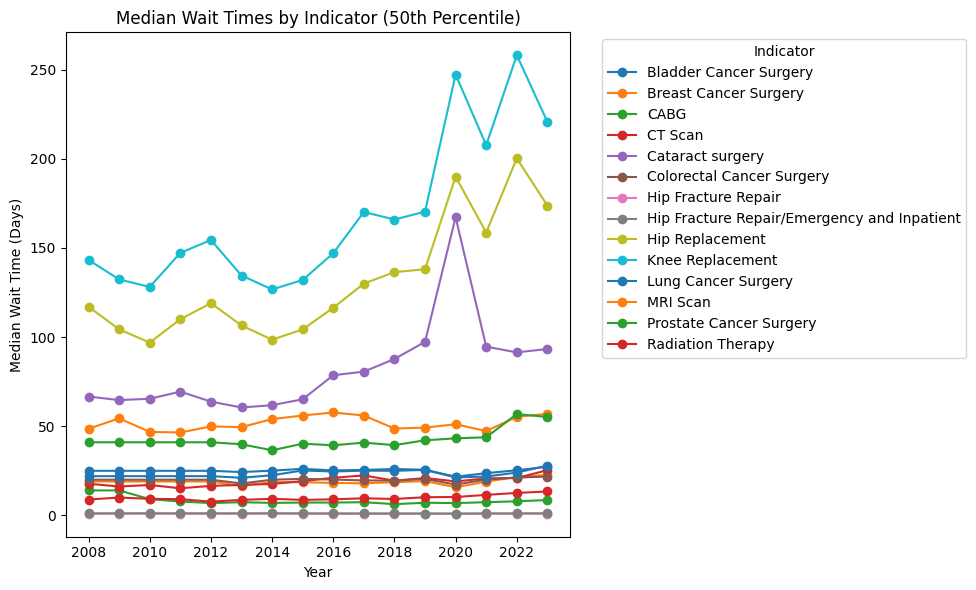

In [8]:
aggregate_df = (
    median_df
    .groupby(['Data year', 'Indicator'])['Indicator result']
    .mean()
    .reset_index()
)
pivot_median = aggregate_df.pivot(
    index='Data year',
    columns='Indicator',
    values='Indicator result'
).sort_index()

plt.figure(figsize=(10, 6))
for indicator in pivot_median.columns:
    plt.plot(pivot_median.index, pivot_median[indicator], marker='o', label=indicator)

plt.xlabel('Year')
plt.ylabel('Median Wait Time (Days)')
plt.title('Median Wait Times by Indicator (50th Percentile)')
plt.legend(title='Indicator', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
aggregate_df.head()

,Data year,Indicator,Indicator result
0,2008,Bladder Cancer Surgery,25.00
1,2008,Breast Cancer Surgery,19.00
2,2008,CABG,14.00
3,2008,CT Scan,17.75
4,2008,Cataract surgery,66.65


In [10]:
error_list = []
for indicator in pivot_median.columns:
    series = pivot_median[indicator].dropna().sort_index()
    naive_forecast = series.shift(1)
    eval_df = pd.DataFrame({
        'actual': series,
        'naive': naive_forecast
    }).dropna()
    
    mae = np.mean(np.abs(eval_df['actual'] - eval_df['naive']))
    rmse = np.sqrt(np.mean((eval_df['actual'] - eval_df['naive'])**2))
    
    error_list.append({
        'Indicator': indicator,
        'MAE': mae,
        'RMSE': rmse
    })

errors_df = pd.DataFrame(error_list)

errors_df

,Indicator,MAE,RMSE
0,Bladder Cancer Surgery,0.940000,1.395469
1,Breast Cancer Surgery,1.126667,1.667133
2,CABG,0.813333,1.411382
3,CT Scan,1.606667,1.889091
4,Cataract surgery,13.336667,26.551626
5,Colorectal Cancer Surgery,0.946667,1.398094
6,Hip Fracture Repair,0.036467,0.051124
7,Hip Fracture Repair/Emergency and Inpatient,0.023467,0.025665
8,Hip Replacement,16.900000,21.914303
9,Knee Replacement,21.686667,29.717414


Visualization of Q2

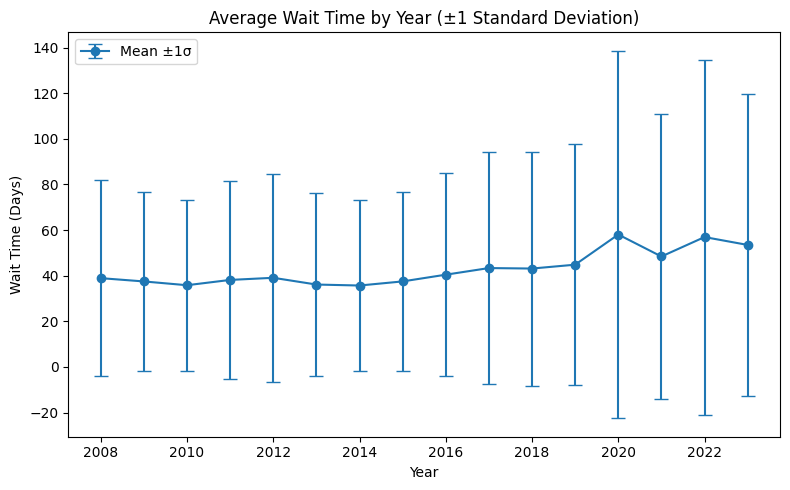

In [11]:
yearly = aggregate_df.groupby('Data year')['Indicator result'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('q1', lambda x: x.quantile(0.25)),
    ('q3', lambda x: x.quantile(0.75))
]).sort_index()

plt.figure(figsize=(8,5))
plt.errorbar(
    yearly.index,
    yearly['mean'],
    yerr=yearly['std'],
    fmt='-o',
    capsize=5,
    label='Mean ±1σ'
)
plt.title('Average Wait Time by Year (±1 Standard Deviation)')
plt.xlabel('Year')
plt.ylabel('Wait Time (Days)')
plt.legend()
plt.tight_layout()
plt.show()

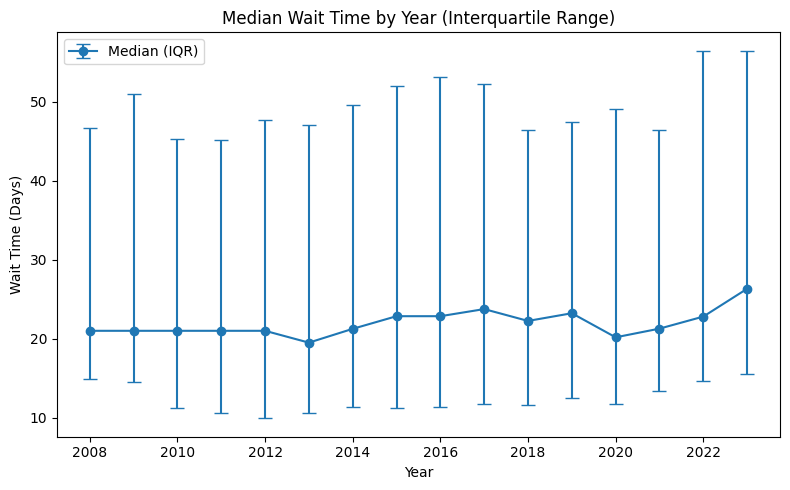

In [12]:
iqr_lower = yearly['median'] - yearly['q1']
iqr_upper = yearly['q3'] - yearly['median']
plt.figure(figsize=(8,5))
plt.errorbar(
    yearly.index,
    yearly['median'],
    yerr=[iqr_lower, iqr_upper],
    fmt='-o',
    capsize=5,
    label='Median (IQR)'
)
plt.title('Median Wait Time by Year (Interquartile Range)')
plt.xlabel('Year')
plt.ylabel('Wait Time (Days)')
plt.legend()
plt.tight_layout()
plt.show()


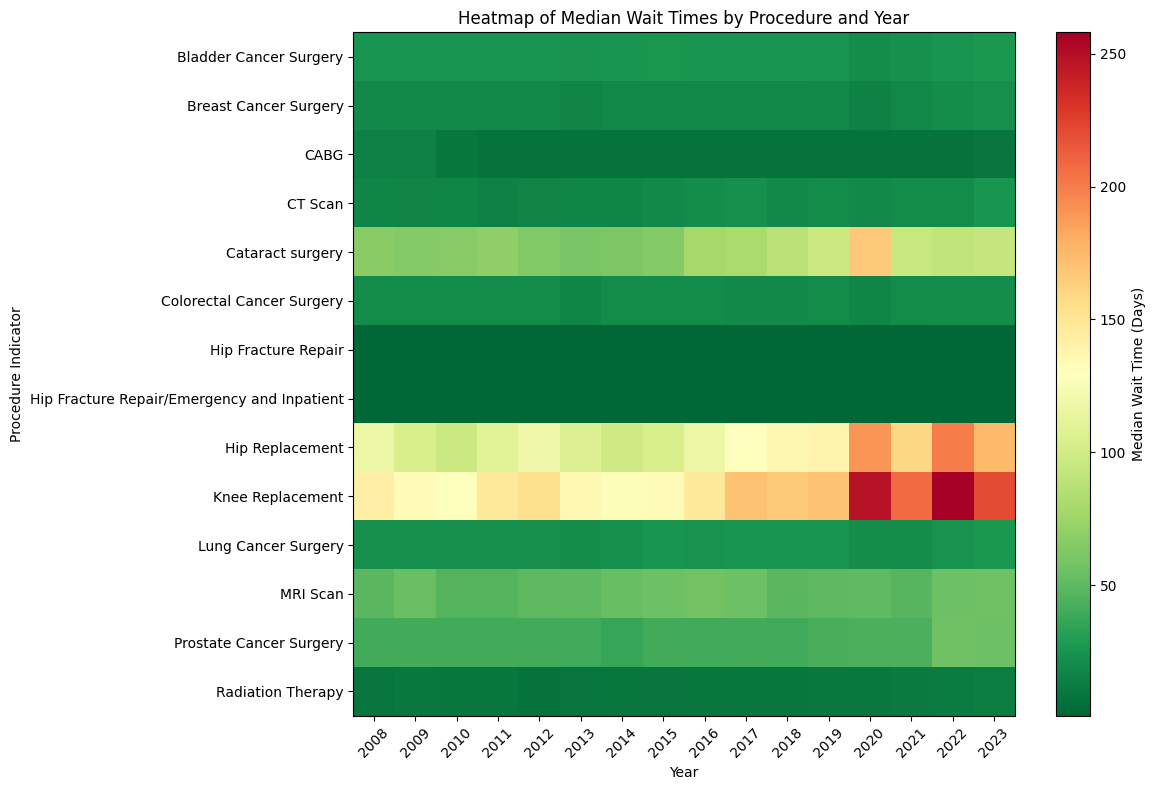

In [13]:
pivot = aggregate_df.pivot(index='Indicator', columns='Data year', values='Indicator result').sort_index()

plt.figure(figsize=(12,8))
im = plt.imshow(pivot, aspect='auto', cmap='RdYlGn_r')
plt.colorbar(im, label='Median Wait Time (Days)')
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.title('Heatmap of Median Wait Times by Procedure and Year')
plt.xlabel('Year')
plt.ylabel('Procedure Indicator')
plt.tight_layout()
plt.show()

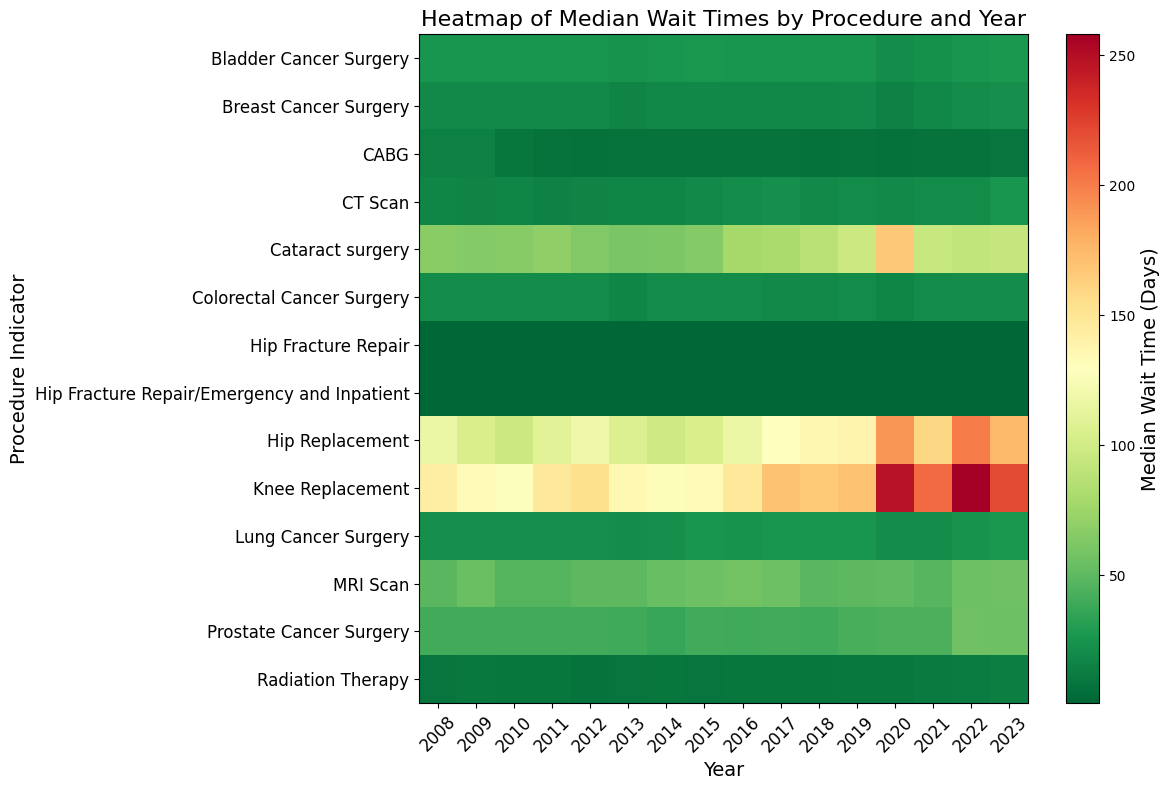

In [15]:
plt.figure(figsize=(12,8))
im = plt.imshow(pivot, aspect='auto', cmap='RdYlGn_r')

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label('Median Wait Time (Days)', fontsize=14)

# Axis value labels (tick labels)
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45, fontsize=12)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index, fontsize=12)

# Axis titles and plot title
plt.title('Heatmap of Median Wait Times by Procedure and Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Procedure Indicator', fontsize=14)

plt.tight_layout()
plt.show()

